# Unit 5 - Financial Planning


In [2]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import json
from MCForecastTools import MCSimulation

%matplotlib inline

In [3]:
# Load .env enviroment variables
load_dotenv('C:/Users/dredm/Desktop/Daryl/Fintech_Bootcamp/Git_Repos/uw-fintech-spring-21/.env')

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [4]:
# Set current amount of crypto assets
my_btc = 1.2

my_eth = 5.3


In [5]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [6]:
# Fetch current BTC price
btc_response = requests.get(btc_url)
btc_response = btc_response.json()

#print json to screen with indent to view the file and determine how to reference price field
#print(json.dumps(btc_response, indent=4))

btc_price = (btc_response['data']['1']['quotes']['USD']['price'])

# Fetch current ETH price
eth_response = requests.get(eth_url)
eth_response = eth_response.json()

#print json to screen with indent to view the file and determine how to reference price field
#print(json.dumps(eth_response, indent=4))

eth_price = eth_response['data']['1027']['quotes']['USD']['price']

# Compute current value of my crypto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $65286.00
The current value of your 5.3 ETH is $8943.22


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Current amount of shares
shares = {
    'shares':[200, 50]
}

In [8]:
# Set Alpaca API key and secret
alp_api_key = os.getenv("ALPACA_API_KEY")
alp_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alp_api_key,
    alp_secret_key,
    api_version = "v2"
)
#Test Alpaca keys to make sure they return string types
print(f"Key type:{type(alp_api_key)}")
print(f"Key type: {type(alp_secret_key)}")

Key type:<class 'str'>
Key type: <class 'str'>


In [9]:
# Format current date as ISO format
start_date = pd.Timestamp("2019-03-22", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2019-03-22", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

df_shares = pd.DataFrame(shares, index=tickers)

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG

df_portfolio = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000
).df

# Preview DataFrame
df_portfolio

AGG                                       SPY  \
                             open     high     low   close   volume    open   
time                                                                          
2019-03-22 00:00:00-04:00  108.46  108.755  108.37  108.63  2293602  283.22   

                                                                
                               high     low   close     volume  
time                                                            
2019-03-22 00:00:00-04:00  283.8034  279.18  279.25  109874331

In [10]:
# Pick AGG and SPY close prices
agg_close_price = float(df_portfolio['AGG']['close'])
spy_close_price = float(df_portfolio['SPY']['close'])

#drop the time part of date time stamp
df_portfolio.index = df_portfolio.index.date

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $108.63
Current SPY closing price: $279.25


In [11]:
# Compute the current value of shares
my_spy = df_shares.loc['SPY']['shares']
my_agg = df_shares.loc['AGG']['shares']
my_spy_value = my_spy * spy_close_price 
my_agg_value = my_agg * agg_close_price
# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $13962.50
The current value of your 200 AGG shares is $21726.00


### Savings Health Analysis

In [12]:
# Set monthly household income
monthly_income = 12000

# Create savings DataFrame
assets = ['crypto', 'stocks']
#need to bring crypto value down
crypto_value = my_btc_value + my_eth_value
stocks_value = my_spy_value + my_agg_value
asset_value = {
    'amount':[crypto_value, stocks_value]
}
df_savings = pd.DataFrame(asset_value, index=assets)
# Display savings DataFrame
display(df_savings)

,amount
crypto,74229.22
stocks,35688.50


<AxesSubplot:title={'center':'Distribution of Savings'}, ylabel='amount'>

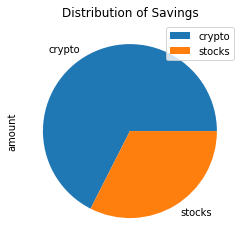

In [13]:
# Plot savings pie chart
df_savings.plot(kind='pie', y='amount',title='Distribution of Savings')

In [14]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = crypto_value + stocks_value

# Validate saving health
if total_savings > emergency_fund:
    print("Congratulations! You have enough money in your emergency fund.")
else:
    print("Unfortunately, you don't have enough money in your emergency fund.")

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [15]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-03-22', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-03-22', tz='America/New_York').isoformat()

In [16]:
# Get 5 years' worth of historical data for SPY and AGG
#Alpaca limits data pull to 1000 days which is 4 years of data. 

df_stock_data = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000
).df


# Display sample data
df_stock_data.head()

AGG                                        SPY  \
                             open    high      low   close   volume     open   
time                                                                           
2017-03-31 00:00:00-04:00  108.44  108.53  108.420  108.52  3151075  235.905   
2017-04-03 00:00:00-04:00  108.31  108.68  108.300  108.67  3857775  235.800   
2017-04-04 00:00:00-04:00  108.61  108.65  108.520  108.56  1482935  235.000   
2017-04-05 00:00:00-04:00  108.48  108.74  108.453  108.69  1900282  236.260   
2017-04-06 00:00:00-04:00  108.64  108.71  108.480  108.67  1599535  234.950   

                                                              
                             high      low   close    volume  
time                                                          
2017-03-31 00:00:00-04:00  236.51  235.680  235.71  47583793  
2017-04-03 00:00:00-04:00  236.03  233.910  235.37  58627715  
2017-04-04 00:00:00-04:00  235.58  234.555  235.51  43130784  
2017-04-05 00:00:00-04:00  237.39  234.540  234.77  84819899  
2017-04-06 00:00:00-04:00  236.04  234.425  235.39  53559902

In [17]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40, .60],
    num_simulation = 500,
    num_trading_days = 252*30    
)

In [18]:
# Printing the simulation input data
MC_30_year.portfolio_data.head()

AGG                                    \
                             open    high      low   close   volume   
time                                                                  
2017-03-31 00:00:00-04:00  108.44  108.53  108.420  108.52  3151075   
2017-04-03 00:00:00-04:00  108.31  108.68  108.300  108.67  3857775   
2017-04-04 00:00:00-04:00  108.61  108.65  108.520  108.56  1482935   
2017-04-05 00:00:00-04:00  108.48  108.74  108.453  108.69  1900282   
2017-04-06 00:00:00-04:00  108.64  108.71  108.480  108.67  1599535   

                                            SPY                           \
                          daily_return     open    high      low   close   
time                                                                       
2017-03-31 00:00:00-04:00          NaN  235.905  236.51  235.680  235.71   
2017-04-03 00:00:00-04:00     0.001382  235.800  236.03  233.910  235.37   
2017-04-04 00:00:00-04:00    -0.001012  235.000  235.58  234.555  235.51   
2017-04-05 00:00:00-04:00     0.001197  236.260  237.39  234.540  234.77   
2017-04-06 00:00:00-04:00    -0.000184  234.950  236.04  234.425  235.39   

                                                  
                             volume daily_return  
time                                              
2017-03-31 00:00:00-04:00  47583793          NaN  
2017-04-03 00:00:00-04:00  58627715    -0.001442  
2017-04-04 00:00:00-04:00  43130784     0.000595  
2017-04-05 00:00:00-04:00  84819899    -0.003142  
2017-04-06 00:00:00-04:00  53559902     0.002641

In [19]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.994074,0.996092,1.014301,1.003132,0.996923,0.989977,0.990927,1.002629,0.994152,0.995282,...,0.994542,1.009155,0.995219,1.006382,1.000172,1.005499,1.014174,0.990236,1.006509,0.995458
2,0.990518,0.993921,1.009378,0.999186,0.990107,0.999279,0.987779,1.010449,0.997429,0.997456,...,0.982541,1.011991,0.992596,1.013556,1.000741,0.997578,1.019984,0.981197,1.004475,0.998632
3,1.002023,0.979392,1.006171,1.001866,0.998648,0.992597,0.986629,1.011720,0.994818,0.994066,...,0.983528,1.021960,0.983427,1.003000,1.007591,1.009884,1.024444,0.980940,0.999512,0.992573
4,1.009078,0.984916,1.010425,0.996027,1.005929,0.990151,0.994574,1.000553,1.005835,1.006507,...,0.976855,1.027559,0.990719,0.999873,1.022900,1.007417,1.023430,0.987837,0.997152,0.983945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,8.415734,10.836250,21.367909,4.602693,26.638697,25.135597,89.840836,59.936526,8.353745,6.620089,...,29.910860,6.869808,31.155356,19.687200,9.592068,11.040429,22.359658,42.683121,5.263708,15.653301
7557,8.414449,10.866691,21.627074,4.593372,26.818123,25.296971,88.531889,59.281786,8.334236,6.620888,...,29.573907,6.853187,31.301927,19.676237,9.650389,10.951213,22.110633,42.703378,5.298319,15.804118
7558,8.433534,11.023113,21.624437,4.639775,27.072891,25.257941,89.129288,59.588285,8.351693,6.596334,...,29.615220,6.852314,31.743284,19.721205,9.618873,11.120599,22.776866,42.291442,5.286314,15.694772
7559,8.444063,10.975604,21.469007,4.639990,27.235565,24.492214,88.724388,60.097518,8.372136,6.567160,...,29.628241,6.874516,31.637546,19.883076,9.557569,10.905872,22.791438,42.654055,5.344310,15.773898


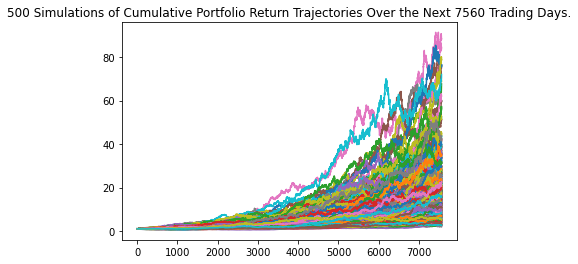

In [20]:
# Plot simulation outcomes
line_plot = MC_30_year.plot_simulation()

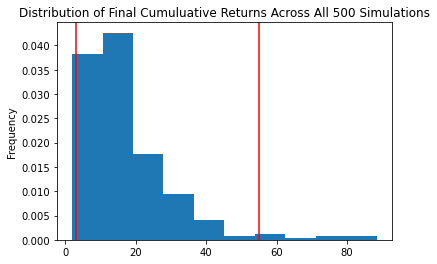

In [21]:
# Plot probability distribution and confidence intervals
plot_dist = MC_30_year.plot_distribution()

### Retirement Analysis

In [22]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats = MC_30_year.summarize_cumulative_return()

# Print summary statistics
print(summary_stats)

count           500.000000
mean             17.285805
std              13.064044
min               1.948577
25%               8.592642
50%              13.990353
75%              21.957448
max              88.311128
95% CI Lower      3.108671
95% CI Upper     54.821909
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [23]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary_stats[8]*initial_investment,2)
ci_upper = round(summary_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $62173.41 and $1096438.18


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [24]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summary_stats[8]*initial_investment,2)
ci_upper = round(summary_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $93260.12 and $1644657.28


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [25]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.30, .70],
    num_simulation = 500,
    num_trading_days = 252*5    
)

In [26]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000063,0.994433,0.991635,1.009302,1.008237,1.008705,1.003163,0.997954,0.994538,0.995058,...,0.998264,0.997339,1.006208,0.999782,1.008932,0.991756,0.987425,1.011029,1.002785,1.003974
2,1.021838,1.005286,0.995621,1.011410,1.006033,0.993851,1.005526,1.004490,0.997287,1.008795,...,1.018822,1.007500,1.019157,0.989049,1.016352,0.991537,0.987006,0.993375,1.012451,1.000441
3,1.015138,0.999294,0.993967,0.997861,1.022720,1.007444,1.012539,1.004602,0.995124,1.020044,...,1.007465,1.010193,1.025254,0.975766,1.018534,0.982461,0.985923,0.980620,1.027673,1.021099
4,1.013206,1.004437,0.986692,1.002911,1.034718,1.010208,1.027696,1.004192,1.001041,1.007339,...,1.000086,1.005608,1.027831,0.964212,1.016627,0.991912,0.990106,0.996147,1.034388,1.030254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.248082,1.883383,2.367218,1.582197,3.345484,1.531552,1.585108,1.455676,1.859586,1.929927,...,1.509229,1.119092,0.906589,1.847124,1.597582,1.822296,1.849187,1.264221,1.176299,1.719620
1257,1.245587,1.864300,2.362030,1.574683,3.378141,1.514066,1.574945,1.431668,1.881492,1.954734,...,1.514066,1.125358,0.907976,1.860052,1.590824,1.840809,1.836440,1.263796,1.150998,1.706139
1258,1.248324,1.859915,2.394398,1.597677,3.348231,1.488352,1.579067,1.444247,1.895279,1.972140,...,1.519088,1.138602,0.896613,1.872227,1.617827,1.867563,1.858022,1.256143,1.145520,1.700135
1259,1.239788,1.864230,2.381914,1.590346,3.383603,1.476860,1.600808,1.442905,1.900935,1.988936,...,1.519985,1.141338,0.894101,1.889347,1.602791,1.894296,1.883317,1.256790,1.150631,1.692435


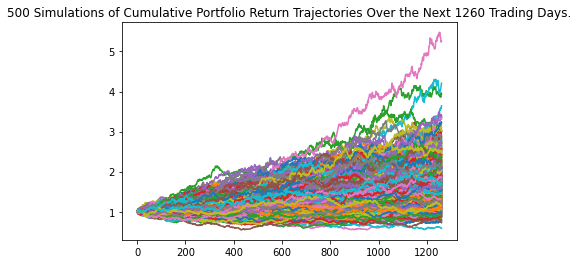

In [27]:
# Plot simulation outcomes
five_yr_line_plot = MC_5_year.plot_simulation()

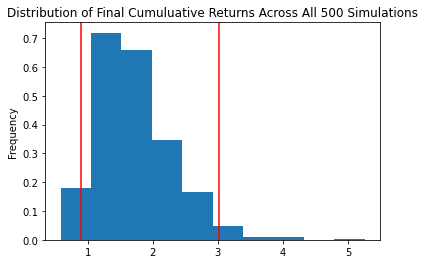

In [28]:
# Plot probability distribution and confidence intervals
five_yr_plot_dist = MC_5_year.plot_distribution()

In [29]:
# Fetch summary statistics from the Monte Carlo simulation results
five_summary_stats = MC_5_year.summarize_cumulative_return()

# Print summary statistics
print(five_summary_stats)

count           500.000000
mean              1.717067
std               0.582271
min               0.584861
25%               1.286327
50%               1.632012
75%               2.018130
max               5.256532
95% CI Lower      0.899061
95% CI Upper      3.011395
Name: 1260, dtype: float64


In [30]:
# Set initial investment
initial_investment_2 = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(five_summary_stats[8] * initial_investment_2,2)
ci_upper_five = round(five_summary_stats[9] * initial_investment_2,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_2} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $53943.63 and $180683.73


### Ten Years Retirement Option

In [31]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.10, .90],
    num_simulation = 500,
    num_trading_days = 252*10    
)

In [32]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003860,1.000139,0.998027,1.004370,0.989074,1.008643,1.002363,1.023457,1.014361,0.981981,...,1.011161,0.994982,1.015895,1.002403,1.000755,1.000652,1.014022,0.990189,0.995965,1.006430
2,1.012833,1.005630,0.979479,1.012618,0.979259,1.018207,1.012934,1.022815,1.009200,0.979402,...,1.017996,0.982409,1.016277,1.013723,0.985265,1.003093,1.014482,0.994969,0.996122,1.012364
3,1.007543,1.026732,0.990716,1.029406,0.974547,1.025831,1.004690,1.013054,1.004840,0.986083,...,1.016644,0.980512,1.022977,1.029367,0.966826,1.027103,0.993938,0.977852,0.993964,1.018073
4,0.989516,1.042876,0.993172,1.016523,0.956375,1.014890,1.011344,1.012874,1.010401,0.989809,...,1.003984,0.984763,1.038023,1.045914,0.990578,1.035344,1.002986,0.982074,0.984192,1.028441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,3.582881,5.670501,2.770496,2.222581,1.978085,2.688893,1.933924,5.769454,2.383557,9.876606,...,2.644569,5.228902,11.189605,9.722682,2.571392,3.549126,5.176816,5.520860,4.407881,6.572344
2517,3.601820,5.687089,2.763063,2.255282,1.960284,2.710330,1.951248,5.814375,2.370974,9.972612,...,2.676516,5.319359,11.217557,9.776963,2.539720,3.457343,5.114128,5.604661,4.429359,6.467001
2518,3.616724,5.672568,2.795471,2.249539,1.931987,2.681573,1.926853,5.743037,2.309061,9.895950,...,2.711615,5.289434,11.115488,9.906760,2.511046,3.539969,4.987695,5.639408,4.437301,6.564771
2519,3.667406,5.618038,2.802096,2.262905,1.942356,2.766036,1.912344,5.754597,2.304769,9.936824,...,2.704397,5.442091,11.258173,10.077776,2.472488,3.535924,5.036934,5.668485,4.449763,6.655233


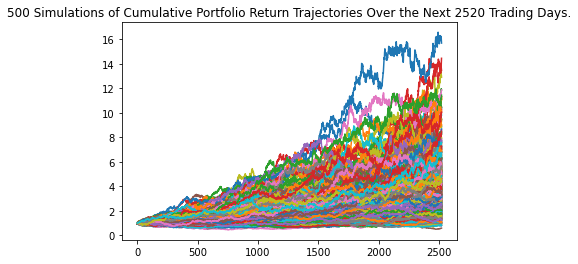

In [33]:
# Plot simulation outcomes
ten_year_line_plot = MC_10_year.plot_simulation()

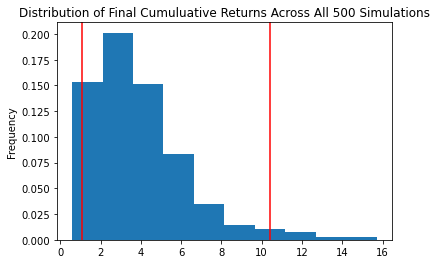

In [34]:
# Plot probability distribution and confidence intervals
ten_year_plot_distribution = MC_10_year.plot_distribution()

In [35]:
# Fetch summary statistics from the Monte Carlo simulation results
ten_summmary_stats = MC_10_year.summarize_cumulative_return()

# Print summary statistics
print(ten_summmary_stats)

count           500.000000
mean              3.926165
std               2.350386
min               0.588667
25%               2.272762
50%               3.412910
75%               5.008710
max              15.699266
95% CI Lower      1.058264
95% CI Upper     10.431471
Name: 2520, dtype: float64


In [36]:
# Set initial investment
initial_investment_3 = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(ten_summmary_stats[8] * initial_investment_3,2)
ci_upper_ten = round(ten_summmary_stats[9] * initial_investment_3,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 10 years will end within in the range of $63495.84 and $625888.29
